# Capstone Project - Battle of Neighborhoods in Dong Da District, Ha Noi
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [1.Introduction: Business Problem](#introduction)
* [2. Data](#data)
* [3. Methodology](#methodology)
* [4. Analysis](#analysis)
* [5. Results and Discussion](#results)
* [6. Conclusion](#conclusion)
* [7. Final Notes](#finalNotes)

## 1. Introduction: Business Problem <a name="introduction"></a>

My friend wanted to open a restaurant or a cafe in Dong Da district, Ha noi, but he didn’t know where to open with little competition. This data analysis article will clarify and may help him with some useful information for his decision

In this project we will try to find an optimal location for a restaurant or cafe. Specifically, this report will be targeted to stakeholders interested in opening an **Restaurant or Cafe** in **Dong Da District, Ha noi**, Viet nam.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## 2. Data <a name="data"></a>

**Based on definition of our problem, factors that will influence our decission are:**
* Detail information of neighborhoods in Dong Da District, list of districts, wards of Dong Da district, Ha Noi from the following URL https://www.gso.gov.vn/dmhc2015/Default.aspx or file data xls from the following https://github.com/TC1894/Coursera_Capstone/blob/master/DONGDA_DISTRICT.xls
* Number of existing restaurants in the neighborhood (any type of restaurant)

**Google map API**

This project would use Google Map API Geocoder to get the Latitude and Longitude of each area

**Foursquare API**

This project would use Four-square API as its prime data gathering source. This API provides the ability to perform location search, location sharing and details about a business.

**install packages**

In [4]:
#!pip install lxml
#!pip install bs4
#!pip install Nominatim
#!pip install geopy
#!pip install geocoder
#!pip install xlrd

### 2.1. Load necessary library

In [5]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import lxml
import folium # map rendering library

import pandas as pd
import lxml
import xlrd

print("Libraries imported.")

Libraries imported.


### 2.2. Get this file excel from https://www.gso.gov.vn/dmhc2015/Default.aspx 
or https://github.com/TC1894/Coursera_Capstone/blob/master/DONGDA_DISTRICT.xls

### 2.3. Load file excel districts, wards of VietNam

In [6]:
df = pd.read_excel('DONGDA_DISTRICT.xls')

WARNING *** file size (8241) not 512 + multiple of sector size (512)


In [7]:
df.head()

,Tỉnh Thành Phố,Mã TP,Quận Huyện,Mã QH,Phường Xã,Mã PX,Cấp,Tên Tiếng Anh
0,Thành phố Hà Nội,1,Quận Đống Đa,6,Phường Cát Linh,178,Phường,NaN
1,Thành phố Hà Nội,1,Quận Đống Đa,6,Phường Văn Miếu,181,Phường,NaN
2,Thành phố Hà Nội,1,Quận Đống Đa,6,Phường Quốc Tử Giám,184,Phường,NaN
3,Thành phố Hà Nội,1,Quận Đống Đa,6,Phường Láng Thượng,187,Phường,NaN
4,Thành phố Hà Nội,1,Quận Đống Đa,6,Phường Ô Chợ Dừa,190,Phường,NaN


In [8]:
df['area'] = df['Phường Xã']+', '+df['Quận Huyện']+', Hà Nội'

df_dongda_district=df[['Phường Xã','Quận Huyện','area']]
df_dongda_district.columns = ['ward','district','area']


In [9]:
df_dongda_district.head(10)

,ward,district,area
0,Phường Cát Linh,Quận Đống Đa,"Phường Cát Linh, Quận Đống Đa, Hà Nội"
1,Phường Văn Miếu,Quận Đống Đa,"Phường Văn Miếu, Quận Đống Đa, Hà Nội"
2,Phường Quốc Tử Giám,Quận Đống Đa,"Phường Quốc Tử Giám, Quận Đống Đa, Hà Nội"
3,Phường Láng Thượng,Quận Đống Đa,"Phường Láng Thượng, Quận Đống Đa, Hà Nội"
4,Phường Ô Chợ Dừa,Quận Đống Đa,"Phường Ô Chợ Dừa, Quận Đống Đa, Hà Nội"
5,Phường Văn Chương,Quận Đống Đa,"Phường Văn Chương, Quận Đống Đa, Hà Nội"
6,Phường Hàng Bột,Quận Đống Đa,"Phường Hàng Bột, Quận Đống Đa, Hà Nội"
7,Phường Láng Hạ,Quận Đống Đa,"Phường Láng Hạ, Quận Đống Đa, Hà Nội"
8,Phường Khâm Thiên,Quận Đống Đa,"Phường Khâm Thiên, Quận Đống Đa, Hà Nội"
9,Phường Thổ Quan,Quận Đống Đa,"Phường Thổ Quan, Quận Đống Đa, Hà Nội"


In [10]:
df_dongda_district.shape

(21, 3)

In [11]:
df_dongda_district.to_csv('VN_HN_DONGDA_DISTRICT.csv',index=False)

### 2.4. Add latitude, longitude by call Google Geocode API

In [12]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Malaysia'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [13]:
coords = [ get_latlng(neighborhood) for neighborhood in df_dongda_district["area"].tolist() ]

In [14]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_dongda_district_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [15]:
df_dongda_district_coords.head()

,Latitude,Longitude
0,21.02931,105.82882
1,21.02768,105.83922
2,21.02768,105.83321
3,21.02358,105.80477
4,21.02092,105.82586


In [16]:
# merge the coordinates into the original dataframe
df_dongda_district_new =pd.concat([df_dongda_district, df_dongda_district_coords], axis=1)
df_dongda_district_new.head()

,ward,district,area,Latitude,Longitude
0,Phường Cát Linh,Quận Đống Đa,"Phường Cát Linh, Quận Đống Đa, Hà Nội",21.02931,105.82882
1,Phường Văn Miếu,Quận Đống Đa,"Phường Văn Miếu, Quận Đống Đa, Hà Nội",21.02768,105.83922
2,Phường Quốc Tử Giám,Quận Đống Đa,"Phường Quốc Tử Giám, Quận Đống Đa, Hà Nội",21.02768,105.83321
3,Phường Láng Thượng,Quận Đống Đa,"Phường Láng Thượng, Quận Đống Đa, Hà Nội",21.02358,105.80477
4,Phường Ô Chợ Dừa,Quận Đống Đa,"Phường Ô Chợ Dừa, Quận Đống Đa, Hà Nội",21.02092,105.82586


**save dataframe to csv**

In [17]:
# save the DataFrame as CSV file
df_dongda_district_new.to_csv("VN_HN_DONGDA_DISTRICT_LATLONG", index=False)

### 2.5. Create a map of Dong da district's Hà Nội with neighborhoods superimposed on top

In [18]:
address='Đống Đa, Hà Nội, Việt Nam'
geolocator = Nominatim(user_agent="HaNoi")

location = geolocator.geocode(address)
lat_HN=location.latitude
long_HN =location.longitude
print('The geograpical coodinate of Dong Da District, HaNoi are {},{}.'.format(lat_HN,long_HN))

The geograpical coodinate of Dong Da District, HaNoi are 21.0128913,105.8277098.


In [52]:
map_HN = folium.Map(location=[lat_HN, long_HN], zoom_start=13)

# add markers to map
for lat, lng, Neighbourhood in zip(df_dongda_district_new['Latitude'], df_dongda_district_new['Longitude'], df_dongda_district_new['ward']):
    label = '{}'.format(Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_HN)  
    
map_HN

In [20]:
# save the map as HTML file
map_HN.save('map_HN.html')

### 2.6. Use the Foursquare API to explore the neighborhoods

In [21]:
# define Foursquare Credentials and Version
CLIENT_ID='1QOE1NIUN3XHN0WH2PUFTX02E4OVH2WJTDZ1HLX01JUZKXD4'
CLIENT_SECRET='12OUF5GTP5NCYOGLEBLIVLDQBQISD3XCE2EBKH5TWGY4E520'
VERSION=20180605

In [22]:
# defining radius and limit of venues to get
radius=500
LIMIT=100

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
Hanoi_venues=getNearbyVenues(names=df_dongda_district_new['area'],
                               latitudes=df_dongda_district_new['Latitude'],
                               longitudes=df_dongda_district_new['Longitude'],
                              )

Phường Cát Linh, Quận Đống Đa, Hà Nội
Phường Văn Miếu, Quận Đống Đa, Hà Nội
Phường Quốc Tử Giám, Quận Đống Đa, Hà Nội
Phường Láng Thượng, Quận Đống Đa, Hà Nội
Phường Ô Chợ Dừa, Quận Đống Đa, Hà Nội
Phường Văn Chương, Quận Đống Đa, Hà Nội
Phường Hàng Bột, Quận Đống Đa, Hà Nội
Phường Láng Hạ, Quận Đống Đa, Hà Nội
Phường Khâm Thiên, Quận Đống Đa, Hà Nội
Phường Thổ Quan, Quận Đống Đa, Hà Nội
Phường Nam Đồng, Quận Đống Đa, Hà Nội
Phường Trung Phụng, Quận Đống Đa, Hà Nội
Phường Quang Trung, Quận Đống Đa, Hà Nội
Phường Trung Liệt, Quận Đống Đa, Hà Nội
Phường Phương Liên, Quận Đống Đa, Hà Nội
Phường Thịnh Quang, Quận Đống Đa, Hà Nội
Phường Trung Tự, Quận Đống Đa, Hà Nội
Phường Kim Liên, Quận Đống Đa, Hà Nội
Phường Phương Mai, Quận Đống Đa, Hà Nội
Phường Ngã Tư Sở, Quận Đống Đa, Hà Nội
Phường Khương Thượng, Quận Đống Đa, Hà Nội


In [25]:
Hanoi_venues.shape

(246, 7)

In [26]:
Hanoi_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Phường Cát Linh, Quận Đống Đa, Hà Nội",21.02931,105.82882,Highlands Coffee,21.029605,105.827811,Coffee Shop
1,"Phường Cát Linh, Quận Đống Đa, Hà Nội",21.02931,105.82882,Pullman Hanoi,21.029652,105.828273,Hotel
2,"Phường Cát Linh, Quận Đống Đa, Hà Nội",21.02931,105.82882,Chân Gà Nướng Việt Hà,21.030472,105.831805,BBQ Joint
3,"Phường Cát Linh, Quận Đống Đa, Hà Nội",21.02931,105.82882,Zennova Massage,21.029979,105.825851,Massage Studio
4,"Phường Cát Linh, Quận Đống Đa, Hà Nội",21.02931,105.82882,Grille6 Steakhouse,21.027156,105.827672,Steakhouse


In [27]:
Hanoi_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Phường Cát Linh, Quận Đống Đa, Hà Nội",21,21,21,21,21,21
"Phường Hàng Bột, Quận Đống Đa, Hà Nội",5,5,5,5,5,5
"Phường Khâm Thiên, Quận Đống Đa, Hà Nội",6,6,6,6,6,6
"Phường Khương Thượng, Quận Đống Đa, Hà Nội",10,10,10,10,10,10
"Phường Kim Liên, Quận Đống Đa, Hà Nội",12,12,12,12,12,12
"Phường Láng Hạ, Quận Đống Đa, Hà Nội",14,14,14,14,14,14
"Phường Láng Thượng, Quận Đống Đa, Hà Nội",8,8,8,8,8,8
"Phường Nam Đồng, Quận Đống Đa, Hà Nội",10,10,10,10,10,10
"Phường Ngã Tư Sở, Quận Đống Đa, Hà Nội",12,12,12,12,12,12


In [28]:
print('There are {} uniques categories.'.format(len(Hanoi_venues['Venue Category'].unique())))

There are 69 uniques categories.


In [29]:
# print out the list of categories
Hanoi_venues['Venue Category'].unique()[:50]

array(['Coffee Shop', 'Hotel', 'BBQ Joint', 'Massage Studio',
       'Steakhouse', 'Fried Chicken Joint', 'Wings Joint', 'Wedding Hall',
       'Lounge', 'Rock Club', 'Vegetarian / Vegan Restaurant',
       'Soccer Stadium', 'Italian Restaurant', 'Malay Restaurant',
       'Dessert Shop', 'Asian Restaurant', 'Café', 'Supermarket',
       'Confucian Temple', 'Hotpot Restaurant', 'Vietnamese Restaurant',
       'Sandwich Place', 'French Restaurant', 'Bar', 'Art Museum',
       'Chocolate Shop', 'Bakery', 'Himalayan Restaurant', 'Food',
       'Bistro', 'Korean Restaurant', 'Mongolian Restaurant', 'Park',
       'Motel', 'Venezuelan Restaurant', 'Noodle House',
       'Japanese Restaurant', 'Pizza Place', 'Shoe Store', 'Multiplex',
       'Bubble Tea Shop', 'Ramen Restaurant', 'Tea Room', 'Garden',
       'Seafood Restaurant', 'Karaoke Bar', 'Fast Food Restaurant',
       'Lake', 'Brewery', 'Concert Hall'], dtype=object)

**Check how many venues were returned for each neighborhood**

In [30]:
HN_DongDa_venues = Hanoi_venues.groupby('Venue Category').count()

In [31]:
HN_DongDa_venues = HN_DongDa_venues.reindex(columns=['Neighbourhood'])
HN_DongDa_venues = HN_DongDa_venues.sort_values(by=['Neighbourhood'], ascending=False).head(20)
HN_DongDa_venues.to_csv('HN_DongDa_venues.csv')

**Draw char**

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
HN_venues_bar = pd.read_csv('HN_DongDa_venues.csv')

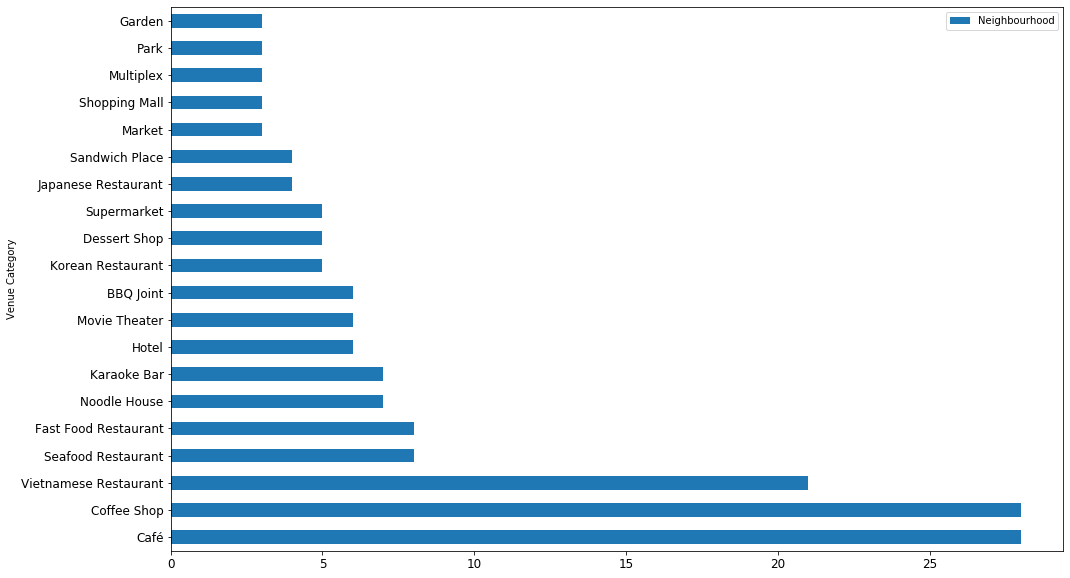

In [33]:
HN_venues_bar.plot.barh(x='Venue Category',fontsize = 12, figsize=(16, 10),stacked=True);


In [34]:
# one hot encoding
hn_onehot = pd.get_dummies(Hanoi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hn_onehot['Neighbourhood'] = Hanoi_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [hn_onehot.columns[-1]] + list(hn_onehot.columns[:-1])
hn_onehot.head()

,Arepa Restaurant,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Bistro,Bookstore,Brewery,Bridal Shop,Bubble Tea Shop,Bulgarian Restaurant,Café,Chocolate Shop,Coffee Shop,College Cafeteria,Concert Hall,Confucian Temple,Dessert Shop,Fast Food Restaurant,Food,Food Truck,French Restaurant,Fried Chicken Joint,Garden,Gym / Fitness Center,Himalayan Restaurant,History Museum,Hotel,Hotpot Restaurant,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Korean Restaurant,Lake,Lounge,Malay Restaurant,Market,Massage Studio,Mongolian Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Noodle House,Park,Pet Store,Pizza Place,Ramen Restaurant,Rock Club,Sake Bar,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Soba Restaurant,Soccer Stadium,Spa,Steakhouse,Supermarket,Tea Room,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wedding Hall,Wings Joint,Women's Store,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Phường Cát Linh, Quận Đống Đa, Hà Nội"
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Phường Cát Linh, Quận Đống Đa, Hà Nội"
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Phường Cát Linh, Quận Đống Đa, Hà Nội"
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Phường Cát Linh, Quận Đống Đa, Hà Nội"
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,"Phường Cát Linh, Quận Đống Đa, Hà Nội"


**Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [35]:
HN_grouped=hn_onehot.groupby('Neighbourhood').mean().reset_index()
HN_grouped

,Neighbourhood,Arepa Restaurant,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Bistro,Bookstore,Brewery,Bridal Shop,Bubble Tea Shop,Bulgarian Restaurant,Café,Chocolate Shop,Coffee Shop,College Cafeteria,Concert Hall,Confucian Temple,Dessert Shop,Fast Food Restaurant,Food,Food Truck,French Restaurant,Fried Chicken Joint,Garden,Gym / Fitness Center,Himalayan Restaurant,History Museum,Hotel,Hotpot Restaurant,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Korean Restaurant,Lake,Lounge,Malay Restaurant,Market,Massage Studio,Mongolian Restaurant,Motel,Motorcycle Shop,Movie Theater,Multiplex,Noodle House,Park,Pet Store,Pizza Place,Ramen Restaurant,Rock Club,Sake Bar,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Soba Restaurant,Soccer Stadium,Spa,Steakhouse,Supermarket,Tea Room,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wedding Hall,Wings Joint,Women's Store
0,"Phường Cát Linh, Quận Đống Đa, Hà Nội",0.0000,0.000000,0.047619,0.047619,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.047619,0.000000,0.142857,0.0,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.0,0.095238,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.047619,0.000000,0.047619,0.047619,0.000000,0.047619,0.000000,0.000000,0.047619,0.047619,0.000000
1,"Phường Hàng Bột, Quận Đống Đa, Hà Nội",0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.400000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000
2,"Phường Khâm Thiên, Quận Đống Đa, Hà Nội",0.0000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.166667,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Phường Khương Thượng, Quận Đống Đa, Hà Nội",0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.200000,0.000000,0.100000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000
4,"Phường Kim Liên, Quận Đống Đa, Hà Nội",0.0000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.166667,0.000000,0.166667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.00

**let's print each neighborhood along with the top 5 most common venues**

In [36]:
num_top_venues = 5


for hood in HN_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = HN_grouped[HN_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Phường Cát Linh, Quận Đống Đa, Hà Nội----
                 venue  freq
0          Coffee Shop  0.14
1                Hotel  0.10
2           Steakhouse  0.05
3            Rock Club  0.05
4  Fried Chicken Joint  0.05


----Phường Hàng Bột, Quận Đống Đa, Hà Nội----
                   venue  freq
0                   Café   0.4
1      Korean Restaurant   0.2
2     Seafood Restaurant   0.2
3  Vietnamese Restaurant   0.2
4       Arepa Restaurant   0.0


----Phường Khâm Thiên, Quận Đống Đa, Hà Nội----
                  venue  freq
0           Karaoke Bar  0.17
1   Japanese Restaurant  0.17
2          Noodle House  0.17
3  Fast Food Restaurant  0.17
4           Bridal Shop  0.17


----Phường Khương Thượng, Quận Đống Đa, Hà Nội----
                   venue  freq
0                   Café   0.2
1         History Museum   0.1
2                 Market   0.1
3  Vietnamese Restaurant   0.1
4          Shopping Mall   0.1


----Phường Kim Liên, Quận Đống Đa, Hà Nội----
                   venue  fre

**Let's put that into a pandas dataframe**
<br>First, let's write a function to sort the venues in descending order

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood

In [38]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = HN_grouped['Neighbourhood']

for ind in np.arange(HN_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(HN_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Phường Cát Linh, Quận Đống Đa, Hà Nội",Coffee Shop,Hotel,Wings Joint,Italian Restaurant,Massage Studio,Café,Malay Restaurant,Rock Club,Lounge,Fried Chicken Joint
1,"Phường Hàng Bột, Quận Đống Đa, Hà Nội",Café,Vietnamese Restaurant,Korean Restaurant,Seafood Restaurant,Women's Store,Fried Chicken Joint,Fast Food Restaurant,Food,Food Truck,French Restaurant
2,"Phường Khâm Thiên, Quận Đống Đa, Hà Nội",Karaoke Bar,Bridal Shop,Japanese Restaurant,Noodle House,Fast Food Restaurant,Asian Restaurant,Hotpot Restaurant,Hotel,History Museum,Himalayan Restaurant
3,"Phường Khương Thượng, Quận Đống Đa, Hà Nội",Café,College Cafeteria,Shopping Mall,Multiplex,Vietnamese Restaurant,Coffee Shop,History Museum,Movie Theater,Market,Food
4,"Phường Kim Liên, Quận Đống Đa, Hà Nội",Vietnamese Restaurant,Coffee Shop,Café,Movie Theater,BBQ Joint,Supermarket,Food Truck,Seafood Restaurant,Shopping Mall,Women's Store


## 3. Methodology <a name="methodology"></a>

After data acquisition and cleaning, this project applies **K-mean clustering unsupervised machine learning algorithm** to cluster the venues based on a list of locations for different types of food and beverage service points such as bars, cafes, Chinese restaurants, Vietnamese restaurants, Seafood restaurants, etc. This would give a better understanding of the similarities and dissimilarities between the chosen neighborhoods to retrieve more insights.

Analyze Each Neighborhood, group rows by neighborhood and by taking the mean of the frequency of occurrence of each category. Next, create the new data frame and display the top 10 venues for each neighborhood.

Then use the Kmean algorithm from the sklearn library to divide it into 5 groups with similar properties. Next, assign labels from Kmean result to each neighborhood using the Pandas merge function

In [39]:
# set number of clusters
kclusters = 5

hn_grouped_clustering = HN_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 
# to change use .astype()

array([1, 2, 4, 1, 1, 1, 1, 2, 1, 3, 0, 2, 1, 1, 2, 1, 3, 1, 4, 1, 2])

## 4. Analysis <a name="analysis"></a>

**Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.**

In [40]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)
neighbourhoods_venues_sorted.head()


,Cluster_Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Phường Cát Linh, Quận Đống Đa, Hà Nội",Coffee Shop,Hotel,Wings Joint,Italian Restaurant,Massage Studio,Café,Malay Restaurant,Rock Club,Lounge,Fried Chicken Joint
1,2,"Phường Hàng Bột, Quận Đống Đa, Hà Nội",Café,Vietnamese Restaurant,Korean Restaurant,Seafood Restaurant,Women's Store,Fried Chicken Joint,Fast Food Restaurant,Food,Food Truck,French Restaurant
2,4,"Phường Khâm Thiên, Quận Đống Đa, Hà Nội",Karaoke Bar,Bridal Shop,Japanese Restaurant,Noodle House,Fast Food Restaurant,Asian Restaurant,Hotpot Restaurant,Hotel,History Museum,Himalayan Restaurant
3,1,"Phường Khương Thượng, Quận Đống Đa, Hà Nội",Café,College Cafeteria,Shopping Mall,Multiplex,Vietnamese Restaurant,Coffee Shop,History Museum,Movie Theater,Market,Food
4,1,"Phường Kim Liên, Quận Đống Đa, Hà Nội",Vietnamese Restaurant,Coffee Shop,Café,Movie Theater,BBQ Joint,Supermarket,Food Truck,Seafood Restaurant,Shopping Mall,Women's Store


In [41]:
HN_merged = df_dongda_district_new

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
HN_merged = HN_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='area')

HN_merged.head() # check the last columns!

,ward,district,area,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Phường Cát Linh,Quận Đống Đa,"Phường Cát Linh, Quận Đống Đa, Hà Nội",21.02931,105.82882,1,Coffee Shop,Hotel,Wings Joint,Italian Restaurant,Massage Studio,Café,Malay Restaurant,Rock Club,Lounge,Fried Chicken Joint
1,Phường Văn Miếu,Quận Đống Đa,"Phường Văn Miếu, Quận Đống Đa, Hà Nội",21.02768,105.83922,1,Vietnamese Restaurant,Coffee Shop,Hotel,Café,Sandwich Place,Malay Restaurant,Food,Dessert Shop,Confucian Temple,Park
2,Phường Quốc Tử Giám,Quận Đống Đa,"Phường Quốc Tử Giám, Quận Đống Đa, Hà Nội",21.02768,105.83321,1,Pizza Place,Soccer Stadium,Noodle House,Coffee Shop,Mongolian Restaurant,Café,Rock Club,Shoe Store,Confucian Temple,Fried Chicken Joint
3,Phường Láng Thượng,Quận Đống Đa,"Phường Láng Thượng, Quận Đống Đa, Hà Nội",21.02358,105.80477,1,Coffee Shop,Bubble Tea Shop,Ramen Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Multiplex,French Restaurant,Dessert Shop,Fast Food Restaurant,Food
4,Phường Ô Chợ Dừa,Quận Đống Đa,"Phường Ô Chợ Dừa, Quận Đống Đa, Hà Nội",21.02092,105.82586,2,Karaoke Bar,Tea Room,Café,Fast Food Restaurant,Seafood Restaurant,Supermarket,Garden,Vietnamese Restaurant,History Museum,Himalayan Restaurant


**We find that there is no data available for some neighbourhood droping that row**

In [42]:
HN_merged=HN_merged.dropna()

In [43]:
HN_merged['Cluster_Labels'] = HN_merged.Cluster_Labels.astype(int)
HN_merged.head(10)

,ward,district,area,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Phường Cát Linh,Quận Đống Đa,"Phường Cát Linh, Quận Đống Đa, Hà Nội",21.02931,105.82882,1,Coffee Shop,Hotel,Wings Joint,Italian Restaurant,Massage Studio,Café,Malay Restaurant,Rock Club,Lounge,Fried Chicken Joint
1,Phường Văn Miếu,Quận Đống Đa,"Phường Văn Miếu, Quận Đống Đa, Hà Nội",21.02768,105.83922,1,Vietnamese Restaurant,Coffee Shop,Hotel,Café,Sandwich Place,Malay Restaurant,Food,Dessert Shop,Confucian Temple,Park
2,Phường Quốc Tử Giám,Quận Đống Đa,"Phường Quốc Tử Giám, Quận Đống Đa, Hà Nội",21.02768,105.83321,1,Pizza Place,Soccer Stadium,Noodle House,Coffee Shop,Mongolian Restaurant,Café,Rock Club,Shoe Store,Confucian Temple,Fried Chicken Joint
3,Phường Láng Thượng,Quận Đống Đa,"Phường Láng Thượng, Quận Đống Đa, Hà Nội",21.02358,105.80477,1,Coffee Shop,Bubble Tea Shop,Ramen Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Multiplex,French Restaurant,Dessert Shop,Fast Food Restaurant,Food
4,Phường Ô Chợ Dừa,Quận Đống Đa,"Phường Ô Chợ Dừa, Quận Đống Đa, Hà Nội",21.02092,105.82586,2,Karaoke Bar,Tea Room,Café,Fast Food Restaurant,Seafood Restaurant,Supermarket,Garden,Vietnamese Restaurant,History Museum,Himalayan Restaurant
5,Phường Văn Chương,Quận Đống Đa,"Phường Văn Chương, Quận Đống Đa, Hà Nội",21.02239,105.83581,4,Noodle House,Pizza Place,Asian Restaurant,Bakery,Shoe Store,Fried Chicken Joint,Dessert Shop,Fast Food Restaurant,Food,Food Truck
6,Phường Hàng Bột,Quận Đống Đa,"Phường Hàng Bột, Quận Đống Đa, Hà Nội",21.02072,105.83097,2,Café,Vietnamese Restaurant,Korean Restaurant,Seafood Restaurant,Women's Store,Fried Chicken Joint,Fast Food Restaurant,Food,Food Truck,French Restaurant
7,Phường Láng Hạ,Quận Đống Đa,"Phường Láng Hạ, Quận Đống Đa, Hà Nội",21.01667,105.81095,1,Vietnamese Restaurant,Fast Food Restaurant,Coffee Shop,Concert Hall,Movie Theater,Café,Gym / Fitness Center,Brewery,Lake,BBQ Joint
8,Phường Khâm Thiên,Quận Đống Đa,"Phường Khâm Thiên, Quận Đống Đa, Hà Nội",21.01910,105.83733,4,Karaoke Bar,Bridal Shop,Japanese Restaurant,Noodle House,Fast Food Restaurant,Asian Restaurant,Hotpot Restaurant,Hotel,History Museum,Himalayan Restaurant
9,Phường Thổ Quan,Quận Đống Đa,"Phường Thổ Quan, Quận Đống Đa, Hà Nội",21.01937,105.83127,2,Café,Karaoke Bar,Noodle House,Vietnamese Restaurant,Korean Restaurant,Seafood Restaurant,Motorcycle Shop,Pet Store,Food,Dessert Shop


In [44]:
# create map
map_clusters = folium.Map(location=[lat_HN, long_HN], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(HN_merged['Latitude'], HN_merged['Longitude'], HN_merged['area'], HN_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [53]:
# save the map as HTML file
map_clusters.save('map_clusters.html')

## 5. Results and Discussion <a name="results"></a>

**Cluster 1**

In [45]:
HN_merged.loc[HN_merged['Cluster_Labels'] == 0, HN_merged.columns[[0] + list(range(5, HN_merged.shape[1]))]]

,ward,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Phường Phương Mai,0,Karaoke Bar,Ice Cream Shop,BBQ Joint,Coffee Shop,Garden,Fast Food Restaurant,Food,Food Truck,French Restaurant,Fried Chicken Joint


**Cluster 2**

In [46]:
HN_merged.loc[HN_merged['Cluster_Labels'] == 1, HN_merged.columns[[0] + list(range(5, HN_merged.shape[1]))]]

,ward,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Phường Cát Linh,1,Coffee Shop,Hotel,Wings Joint,Italian Restaurant,Massage Studio,Café,Malay Restaurant,Rock Club,Lounge,Fried Chicken Joint
1,Phường Văn Miếu,1,Vietnamese Restaurant,Coffee Shop,Hotel,Café,Sandwich Place,Malay Restaurant,Food,Dessert Shop,Confucian Temple,Park
2,Phường Quốc Tử Giám,1,Pizza Place,Soccer Stadium,Noodle House,Coffee Shop,Mongolian Restaurant,Café,Rock Club,Shoe Store,Confucian Temple,Fried Chicken Joint
3,Phường Láng Thượng,1,Coffee Shop,Bubble Tea Shop,Ramen Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Multiplex,French Restaurant,Dessert Shop,Fast Food Restaurant,Food
7,Phường Láng Hạ,1,Vietnamese Restaurant,Fast Food Restaurant,Coffee Shop,Concert Hall,Movie Theater,Café,Gym / Fitness Center,Brewery,Lake,BBQ Joint
13,Phường Trung Liệt,1,Coffee Shop,Café,Spa,Japanese Restaurant,Noodle House,Park,Hotpot Restaurant,Sake Bar,Bulgarian Restaurant,Intersection
15,Phường Thịnh Quang,1,Café,Coffee Shop,Spa,Fast Food Restaurant,Sake Bar,Sandwich Place,Bulgarian Restaurant,Noodle House,Japanese Restaurant,Garden
16,Phường Trung Tự,1,Café,Coffee Shop,Women's Store,Soba Restaurant,Dessert Shop,Food Truck,Market,Movie Theater,Rock Club,Seafood Restaurant
17,Phường Kim Liên,1,Vietnamese Restaurant,Coffee Shop,Café,Movie Theater,BBQ Joint,Supermarket,Food Truck,Seafood Restaurant,Shopping Mall,Women's Store
19,Phường Ngã Tư Sở,1,Coffee Shop,Market,Pizza Place,Ice Cream Shop,Fast Food Restaurant,Café,Sandwich Place,Bulgarian Restaurant,Multiplex,Supermarket


**Cluster 3**

In [47]:
HN_merged.loc[HN_merged['Cluster_Labels'] == 2, HN_merged.columns[[0] + list(range(5, HN_merged.shape[1]))]]

,ward,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Phường Ô Chợ Dừa,2,Karaoke Bar,Tea Room,Café,Fast Food Restaurant,Seafood Restaurant,Supermarket,Garden,Vietnamese Restaurant,History Museum,Himalayan Restaurant
6,Phường Hàng Bột,2,Café,Vietnamese Restaurant,Korean Restaurant,Seafood Restaurant,Women's Store,Fried Chicken Joint,Fast Food Restaurant,Food,Food Truck,French Restaurant
9,Phường Thổ Quan,2,Café,Karaoke Bar,Noodle House,Vietnamese Restaurant,Korean Restaurant,Seafood Restaurant,Motorcycle Shop,Pet Store,Food,Dessert Shop
10,Phường Nam Đồng,2,Café,Women's Store,Seafood Restaurant,Garden,Korean Restaurant,Motorcycle Shop,Movie Theater,Pet Store,Karaoke Bar,Spa
12,Phường Quang Trung,2,Women's Store,Garden,Dessert Shop,Coffee Shop,Movie Theater,Café,Seafood Restaurant,Park,Pet Store,Tea Room


**Cluster 4**

In [48]:
HN_merged.loc[HN_merged['Cluster_Labels'] == 3, HN_merged.columns[[0] + list(range(5, HN_merged.shape[1]))]]

,ward,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Phường Trung Phụng,3,Karaoke Bar,Fast Food Restaurant,Café,Bookstore,Garden,Food,Food Truck,French Restaurant,Fried Chicken Joint,Gym / Fitness Center
14,Phường Phương Liên,3,Fast Food Restaurant,BBQ Joint,Seafood Restaurant,Café,Bookstore,Garden,Food,Food Truck,French Restaurant,Fried Chicken Joint


**Cluster 5**

In [49]:
HN_merged.loc[HN_merged['Cluster_Labels'] == 4, HN_merged.columns[[0] + list(range(5, HN_merged.shape[1]))]]

,ward,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Phường Văn Chương,4,Noodle House,Pizza Place,Asian Restaurant,Bakery,Shoe Store,Fried Chicken Joint,Dessert Shop,Fast Food Restaurant,Food,Food Truck
8,Phường Khâm Thiên,4,Karaoke Bar,Bridal Shop,Japanese Restaurant,Noodle House,Fast Food Restaurant,Asian Restaurant,Hotpot Restaurant,Hotel,History Museum,Himalayan Restaurant



**After reviewing the data of each cluster, I have some discussions:**

* At Cluster 1 most common venue is Karaoke Bar. Cafe shop and Restaurant is only ranked 4 to 10, so it is possible to open a cafe in Cluster 1
* At Cluster 2, 3 ,4 focus mainly on Vietnamese restaurants, Cafe, So need to be careful when you intend to open a Vietnamese restaurant or cafe
* Cluster 5, there is no coffee shop, so you can rest assured that you can open a coffee shop without much competition.

## 6. Conclusion <a name="conclusion"></a>

Finally, I have got a small glimpse of how real-life data-science projects look like. I used various types of APIs to collect data, used the Pandas library to eliminate redundant data, used it, and used Python libraries to draw graphs, using unsupervised machine learning algorithms to group data into similar characteristics. From that it is possible to discover the information that is hidden in it, making it easier to make decisions such as where to open a restaurant or a cafe is appropriate and less competitive

## 7. Final Notes <a name="finalNotes"></a> 

This is my assignment: a part of the IBM Data Science Course on Coursera.

The full project Jupiter Notebook from data scraping to preprocessing to results here: https://github.com/TC1894/Coursera_Capstone/blob/master/Battle-of-Neighborhoods-in-DongDa-District-HaNoi.ipynb